## Testing
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [13]:
import matplotlib.pyplot as plt
import palettable as pl
st = plt.style.available[23]
plt.style.use(st)
emr = pl.cartocolors.sequential.Emrld_7.get_mpl_colormap()
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
from quantum_mechanics import matrix_box_potential, get_coeffs, solve_eigenvalues
from plot_functions import *

In [6]:
N = 5000
A = matrix_box_potential(N,order=6)
e, v = solve_eigenvalues(A, N)

In [7]:
n = np.arange(1,N+1)
en = np.pi**2 *n**2
x= np.linspace(0,1,N)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


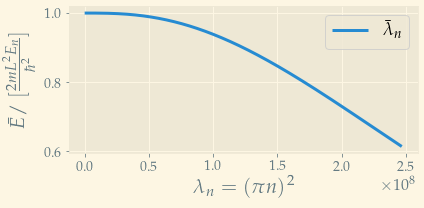

In [39]:
e_vs_lambda(e)

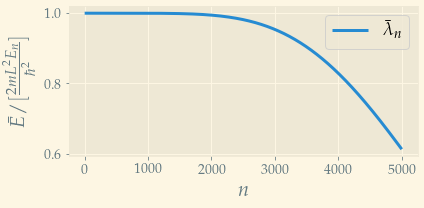

In [40]:
e_vs_n(e)

In [41]:
from scipy.integrate import simps

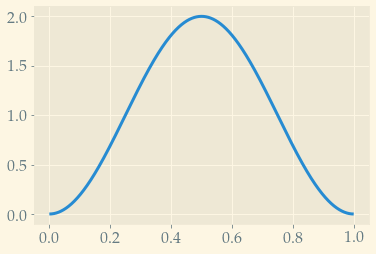

In [42]:
plt.plot(x, np.abs(np.sqrt(N)*v[:,0])**2)

# Orthogonality

In [43]:
v1 = v[:,0]
v2 = v[:,1]

In [44]:
u = np.zeros((100,100))

In [45]:
%%time
for i in range(100):
    for j in range(100):
        u[i,j] = get_coeffs(np.sqrt(N)*v[:,i], np.sqrt(N)*v[:,j])

C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 1.28 s


C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


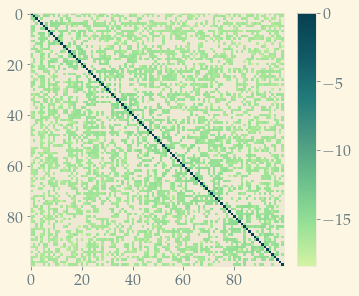

In [72]:
fig = plt.figure(constrained_layout=True)
im = plt.imshow(np.log10(u), cmap =emr)
plt.grid()
cbar= fig.colorbar(im)
plt.savefig("report/img/ortho.png", facecolor=fig.get_facecolor())

In [47]:
get_coeffs(np.sqrt(N)*v1,np.sqrt(N)*v1)

(1.0000000000000002+0j)

In [48]:
psi0 = np.sqrt(2)*np.sin(np.pi*x)

In [49]:
get_coeffs(psi0, psi0)

0.9998

---

# Parallellize multiple solvers

In [11]:
from dask import delayed, compute

In [12]:
from quantum_mechanics import parallellize_solver

In [13]:
# %time parallellize_solver(100, 10000, 50)

# Compare error by stepsize
---

In [73]:
import utils
from quantum_mechanics import error_metric

In [74]:
x = np.linspace(0,1, N)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


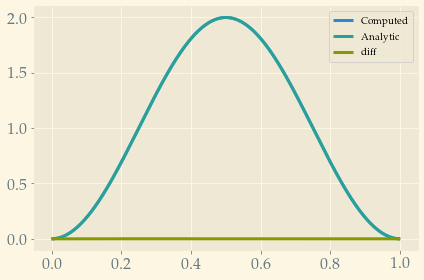

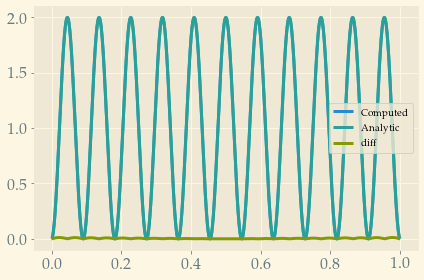

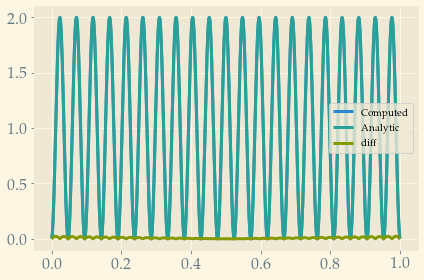

In [75]:
for n in [0, 10, 20]:
    plt.figure(tight_layout=True)
    c = np.sqrt(N)*np.abs(v[:,n])
    a = np.sqrt(2)*np.sin((n+1)*np.pi*x)
    plt.plot(x,np.abs(c)**2, label = "Computed")
    plt.plot(x,np.abs(a)**2, label="Analytic")
    plt.plot(x, np.abs(a**2 - c**2), label = "diff")
#     plt.plot(x, (np.sqrt(2)*np.sin((n+1)*np.pi*x))**2)
    plt.legend()
    plt.show()

In [78]:
%%time
error_list = []
x = np.linspace(0,1, N)
for n in range(N):
    analytic = np.sqrt(2)*np.sin((n+1)*np.pi*x)
    err = error_metric(analytic, np.sqrt(N) * v[:,n])
    error_list.append(err)

Wall time: 862 ms


In [79]:
n= range(N)

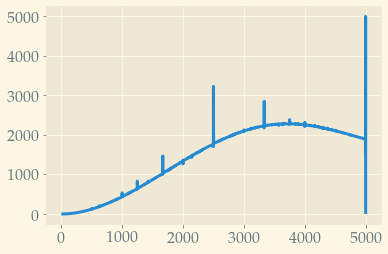

In [80]:
plt.plot(n, error_list)

In [81]:
from utils import get_n_list, load_e_v

In [82]:
n_list =(get_n_list())
n_list.sort()

In [83]:
%%time
gs = [] # Ground states
first = []
second =[]
gse = [] # Ground state energies
e1 = []
e2 = []
for n in n_list:
    e, v = load_e_v(n)
    gs.append(v[:,0])
    first.append(v[:,1])
    second.append(v[:,2])
    
    gse.append(e[0])
    e1.append(e[1])
    e2.append(e[2])
    
    e =[]
    v=[]

Wall time: 1min 10s


In [84]:
from numba import jit

In [85]:
import matplotlib

In [86]:
@jit
def discretization_error(psi_list, n_list, n_excited=0):
    """
    psi_list: List of nth excited states.
    n_excited: nth energy level
    """
    error = []
    for i,n in enumerate(n_list):
        x = np.linspace(0,1, psi_list[i].shape[0])
        analytic = np.sqrt(2)*np.sin((n_excited+1)*np.pi*x)
        err = error_metric(np.sqrt(n) * psi_list[i],analytic)
        error.append(err)
    
    return error

In [90]:
%time gs_error = discretization_error(gs, n_list, 0)
%time first_error = discretization_error(first, n_list, 1)
%time second_error = discretization_error(second, n_list, 2)

Wall time: 472 ms
Wall time: 7.98 ms
Wall time: 7.98 ms


In [91]:
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

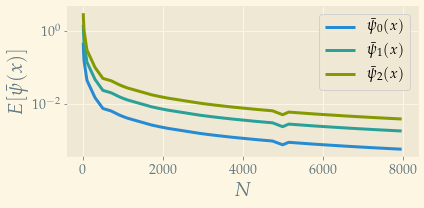

In [97]:
sl = 6
fig = plt.figure(figsize=(6,3),tight_layout=True)
plt.semilogy(n_list[:-sl], gs_error[:-sl], label = fr"$\bar\psi_0(x)$")
plt.semilogy(n_list[:-sl], first_error[:-sl], label = fr"$\bar\psi_1(x)$")
plt.semilogy(n_list[:-sl], second_error[:-sl], label = fr"$\bar\psi_2(x)$")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
plt.ylabel(fr"$E[\bar\psi(x)]$", size=20)
plt.xlabel(fr"$N$", size = 20)
plt.savefig("report/img/discretization_step.png", facecolor=fig.get_facecolor())